# This notebook combines all algorithms in a function

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.signal import find_peaks

In [2]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('../saved_models/vehicle_model.h5')

## Preprocessing

In [3]:
def preprocess_frame(x):
    """preprocess a video frame"""
    
    blur = cv2.blur(x,(5,5)) # filters
    blur0=cv2.medianBlur(blur,5)
    blur1= cv2.GaussianBlur(blur0,(5,5),0)
    blur2= cv2.bilateralFilter(blur1,9,75,75)

    hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV) # color filter

    low = np.array([60, 50, 50]) # mask
    high = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(x,x, mask=mask)
    
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) # gray picture
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY) # threshhold

    return thresh


## Measure

In [4]:
def measure_image(x):
    """take measurements of a given image x"""

    img = x[200:1000, 250:1600] # crop image

    blur = cv2.blur(img,(5,5))
    blur0=cv2.medianBlur(blur,5)
    blur1= cv2.GaussianBlur(blur0,(5,5),0)
    blur2= cv2.bilateralFilter(blur1,9,75,75)
    
    hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV)
    
    low = np.array([60, 40, 50])
    high = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, low, high)
    
    res = cv2.bitwise_and(img,img, mask= mask)
    
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    
    _, img_thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    indexes = np.where(img_thresh>0) # find min and max Array (x and y)

    min_y = min(indexes[0])
    max_y = max(indexes[0])

    min_x = min(indexes[1])
    max_x = max(indexes[1])

    height_pi = max_y - min_y # length and heigth of the car in pixel
    length_pi = max_x - min_x 

    length_mm = length_pi*(3.83) # length and heigth in mm
    height_mm = height_pi*(4.09)


    return(length_mm, height_mm)

## Predict

In [5]:
class_names = ['articulated truck', 'background', 'bicycle', 'bus', 'car', 'motorcycle', 'non motorized vehicle', 'pedestrian', 'pickup truck', 'single unit truck', 'work van']

def predict_image(x):
    """predict a given image"""

    # frame shape = 1920x1080x3
    # add padding -> 1920x1920x3
    img = cv2.copyMakeBorder(x, 420, 420, 0, 0, cv2.BORDER_REPLICATE)
    
    # use smart resizer as in training
    img = tf.keras.preprocessing.image.smart_resize(img, (256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return (class_names[np.argmax(score)], round(100 * np.max(score), 2))

## Process Video

In [6]:
def process_video(path: str):
    """process a given video"""
    cap = cv2.VideoCapture(path)  # capture

    count = 0 # frames passed
    x = [] # frame
    y = [] # amount of pixels
    

    while cap.isOpened(): # do for each frame
        ret, frame = cap.read()

        if ret:
            thresh = preprocess_frame(frame)

            nonzero = np.count_nonzero(thresh) # count nonzero pixels

            x.append(count) # save values for plotting
            y.append(nonzero)
            
            count += 12 # 24/12 frames per second
            cap.set(1, count)

        else:
            break

    a = np.array([x, y]) # find maximum value and index in array
    v = np.amax(a)
    u = np.where(a == v)
    max_frame = u [1][0] *12

    cap.set(1, max_frame) # extract final frame
    ret, image = cap.read()
    plt.imshow(image)

    # take measurements
    length, height = measure_image(image)

    cls, score = predict_image(image) # predict frame

    return (image, length, height, cls, score)


## Output

In [7]:
def print_results(results):
    image, length, height, cls, score = results
    plt.imshow(image)
    print(f'The lenght of the vehicle is approximately {length}mm and the height {height}mm')
    print(f'The vehicle is most likely a {cls} with {score}% certainty')


The lenght of the vehicle is approximately 3630.84mm and the height 1537.84mm
The vehicle is most likely a car with 100.0% certainty


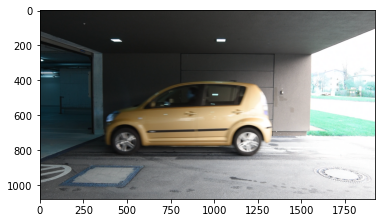

In [8]:
print_results(process_video('../datasets/side_daihatsu.mov'))

The lenght of the vehicle is approximately 5055.6mm and the height 2253.59mm
The vehicle is most likely a car with 99.92% certainty


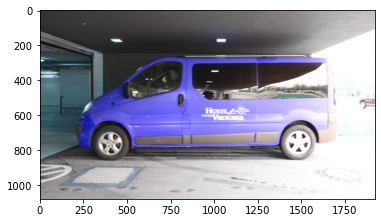

In [9]:
print_results(process_video('../datasets/side_opel.mov'))